## 1.1 Load tweets from csv & add auxiliary functions

In [242]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import *
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn import metrics
from datetime import datetime

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def evaluate(y_true, y_pred):
    hits = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            hits += 1
    print("\nEvaluación:")
    print('-'*40)
    print("Hits:", hits)
    print("Accuracy: {:.4}%".format(100*hits/len(y_true)))
    print("Accuracy: {:.4}%".format(100*metrics.accuracy_score(y_true, y_pred)))
    print('-'*40)
    print("Confusion_matrix:")
    print(metrics.confusion_matrix(y_true, y_pred))
    print('-'*40)
    print(metrics.classification_report(y_true, y_pred))

def pinta_matriz_dispersa(M, nombre_col=None, pre=2):
    filas, columnas = M.shape
    header = nombre_col != None
    pt = PrettyTable(nombre_col, header=header)
    for fila in range(filas):
        vf = M.getrow(fila)
        _, cind = vf.nonzero()
        #f = [vf[0, c] if c in cind else '-' for c in range(columnas)]
        pt.add_row([round(vf[0, c],pre) if c in cind else '-' for c in range(columnas)])
        #print (f)
        #pt.add_row(f)
    return pt



def plot_bar_x(values):
    labels = Counter(values).keys()
    freq_labels = Counter(values).values()
    index = np.arange(len(labels)) # <- this is for plotting purpose
    plt.bar(index, freq_labels)
    plt.xlabel('Polarity', fontsize=9)
    plt.ylabel('Count', fontsize=9)
    plt.xticks(index, labels, fontsize=9, rotation=30)
    plt.title('Frequency of Labels')
    plt.show()
    
def analyzeTweetList(tweets):
    listTweets = []
    lengthTweets = []
    tweetsScores = []
    
    for tweet in tweets:
        listTweets.append(tweet[1])
        lengthTweets.append(len(tweet[1]))
        
        if len(tweet)>3:
            tweetsScores.append(tweet[2])

    print('Number of tweets: '+str(len(tweets)))
    
    plt.hist(lengthTweets, bins=30)
    plt.title("Length of tweets")
    plt.xlabel("Number of characters")
    plt.ylabel("Frecuency")
    plt.show()
    
    if len(tweetsScores)> 0:
        plot_bar_x(tweetsScores)
    

def convertTweetsFileToList(file):
    tweets = []
    for row in csv.reader(file, delimiter = '\t', quotechar='"', escapechar='\\'):
        tweets.append(row)
    
    return tweets

def saveFile(filename, rows):
    with open(filename, 'w', encoding='utf-8') as fh:
        for row in rows:
            line = '\t'.join(row)
            fh.write(line + '\n')
    fh.close()

## 1.2 Data analysis

Number of tweets: 6844


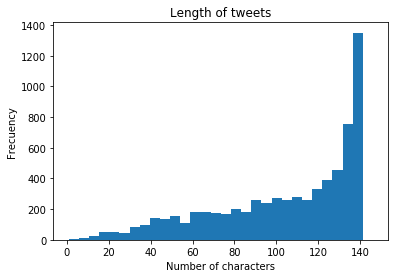

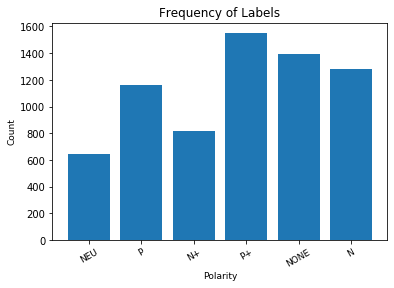

Number of tweets: 57415


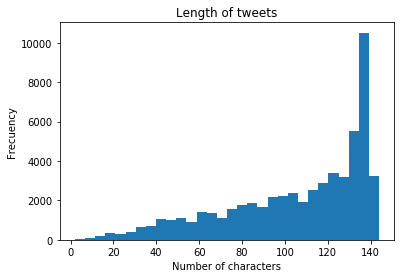

In [36]:
import csv

tweets = convertTweetsFileToList(open('tweets.csv', encoding='utf-8'))
testTweets = convertTweetsFileToList(open('tweets_test.csv', encoding='utf-8'))

analyzeTweetList(tweets)
analyzeTweetList(testTweets)

## 1.3 Load polarity dictionary

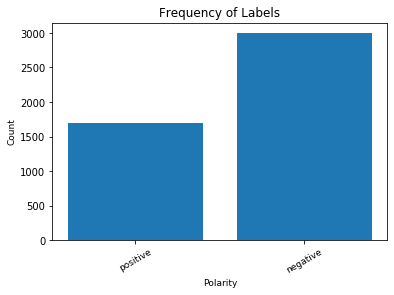

In [3]:
def loadPolarityDictionary(filename):
    # we also add emojis with its scores
    positiveEmojis = [':)', ':-)', ';)', 'xD', 'XD', '=)', ';-)']
    negativeEmojis = [':(', ':-(', ':/', '=/', ':\'(']
    
    dict = {}
    
    for emoji in positiveEmojis:
        dict[emoji] = 'positive'
        
    for emoji in negativeEmojis:
        dict[emoji] = 'negative'
    
    for line in csv.reader(open(filename, encoding='utf-8'), delimiter = '\t'):
        if len(line) > 0 and not line[0].startswith('#'):
            dict[line[0]] = line[1]
    
    scoreList = []
    for word in dict.values():
        scoreList.append(word)
    
    if len(scoreList)> 0:
        plot_bar_x(scoreList)
        
    return dict

polarityDictionary = loadPolarityDictionary('ElhPolar_esV1-1.lex')

## 2.1 Tokenization

In [4]:
from nltk.tokenize import TweetTokenizer
import random

tknzr = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
tokens = [tknzr.tokenize(str(tweet[1])) for tweet in tweets]

random = random.randint(1,len(tweets))
print("Before:\n", tweets[random][1])
print("\nAfter:\n", tokens[random])


Before:
 ¡Lo mejor de mi timeline está disponible! http://t.co/0l0HzKDb ▸ Historias del día por @luisfernandez @asv7777 @savetchildren

After:
 ['¡', 'lo', 'mejor', 'de', 'mi', 'timeline', 'está', 'disponible', '!', 'http://t.co/0l0HzKDb', '▸', 'historias', 'del', 'día', 'por']


## 2.2 Unsupervised model

 ---- Unsupervised Model ---- 

    Example tweet:  Fin de año en Sunderland en el hotel con el @MCFC. El brindis queda para otro día pero los buenos deseos para todos van ahora. ¡Feliz 2012!!

    Real:  P+
    Prediction: P
    Count Neg Words: 1
    Count Pos Words: 3
    Difference: 2

Evaluación:
----------------------------------------
Hits: 2505
Accuracy: 36.6%
Accuracy: 36.6%
----------------------------------------
Confusion_matrix:
[[572  86 167 247 199   9]
 [408 100  92 103 104   6]
 [208  33 100 112 178  12]
 [148   3  47 861 327  11]
 [174  21  97 254 527  86]
 [ 81   9  79 181 857 345]]
----------------------------------------
              precision    recall  f1-score   support

           N       0.36      0.45      0.40      1280
          N+       0.40      0.12      0.19       813
         NEU       0.17      0.16      0.16       643
        NONE       0.49      0.62      0.55      1397
           P       0.24      0.45      0.31      1159
          P+       0.74  

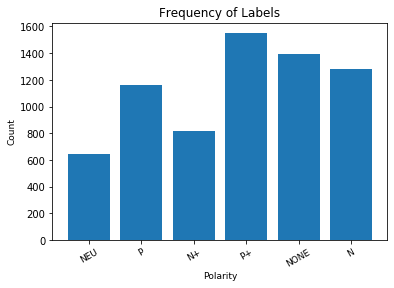

Prediction


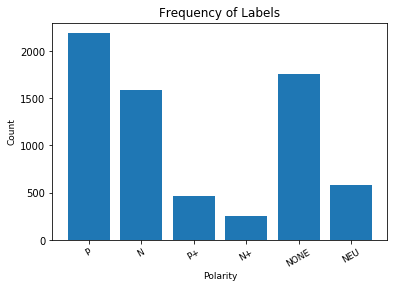

In [163]:
import random

#scoreTags = ["NONE", "N+", "N", "NEU", "P", "P+"]
print(" ---- Unsupervised Model ---- \n")

prediction = []
count_pos = []
count_neg = []
scores = []

def polarizeData(tweet):
    pos = neg = 0
    
    for word in tknzr.tokenize(str(tweet[1])):
        if word in polarityDictionary:
            if polarityDictionary[word] == "positive":
                pos += 1
            elif polarityDictionary[word] == "negative":
                neg += 1
    
    score = pos-neg
    
    if(pos == 0 and neg == 0):
        label = "NONE"
    elif score == 0:
        label = "NEU"
    elif score > 0:
        if score > 2:
            label = "P+"
        else:
            label = "P"
    elif score < 0:
        if score < -2:
            label = "N+"
        else:
            label = "N"
        
    return score, label, pos, neg

for tweet in tweets:
    polarizedData = polarizeData(tweet)
    scores.append(polarizedData[0])
    prediction.append(polarizedData[1])
    count_pos.append(polarizedData[2])
    count_neg.append(polarizedData[3])


real_values = [tweet[2] for tweet in tweets]

random = random.randint(1,len(tweets))

print("    Example tweet: ",tweets[random][1])
print("\n    Real: ", real_values[random])
print("    Prediction:", prediction[random])
print("    Count Neg Words:", count_neg[random])
print("    Count Pos Words:", count_pos[random])
print("    Difference:", scores[random])

evaluate(real_values, prediction)

print("Real")
plot_bar_x(real_values)

print("Prediction")
plot_bar_x(prediction)

modelUnsupervisedAccuracy = metrics.accuracy_score(real_values, prediction)

## 2.3 Supervised model - Matrix of features

### 2.3.1 Clean tweets content

In [6]:
import re

# clean tweets content
def cleanTweet(tweet):
    tweet = re.sub(r'#(\w+)', '', tweet) # hashtags
    tweet = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', tweet) #url
    tweet = re.sub(r'\S*\d+\S*', '', tweet) #digits
    tweet = re.sub(r'[^\w]', ' ', tweet) #non alphanumeric
      
    return tweet

from random import randint

example_tweet = tweets[randint(0,len(tweets))][1]
print(example_tweet)
print(cleanTweet(example_tweet))
print(tknzr.tokenize(cleanTweet(example_tweet)))

Estoy con un Citadelle Reserve (el Rolls Royce de los gin tonics) a la salud de los miles que habéis mandado hoy tuits de todo tipo. Gcs.
Estoy con un Citadelle Reserve  el Rolls Royce de los gin tonics  a la salud de los miles que habéis mandado hoy tuits de todo tipo  Gcs 
['estoy', 'con', 'un', 'citadelle', 'reserve', 'el', 'rolls', 'royce', 'de', 'los', 'gin', 'tonics', 'a', 'la', 'salud', 'de', 'los', 'miles', 'que', 'habéis', 'mandado', 'hoy', 'tuits', 'de', 'todo', 'tipo', 'gcs']


### 2.3.2 Stop words

In [7]:
file = open('stopwords-es.txt', encoding='utf-8')

for row in file:
    stopwords = [re.sub(r'\n', '', row) for row in file]
    
for word in stopwords: 
    if word in polarityDictionary.keys():
        stopwords.remove(word) 
        
print("There are {} stopwords.".format(len(stopwords)))

There are 693 stopwords.


### 2.3.3 Model

- Remove hastags
- Remove urls
- Remove non-alphanumerics
- Remove digits

Finished in 0:00:27.451569

Evaluación:
----------------------------------------
Hits: 853
Accuracy: 41.53%
Accuracy: 41.53%
----------------------------------------
Confusion_matrix:
[[205   8   1 124   5  50]
 [100  26   1  68   6  29]
 [ 89   5   1  47   7  55]
 [ 46   1   0 302  11  45]
 [ 78   3   0 129  34  91]
 [ 57   1   0 123  21 285]]
----------------------------------------
              precision    recall  f1-score   support

           N       0.36      0.52      0.42       393
          N+       0.59      0.11      0.19       230
         NEU       0.33      0.00      0.01       204
        NONE       0.38      0.75      0.50       405
           P       0.40      0.10      0.16       335
          P+       0.51      0.59      0.55       487

    accuracy                           0.42      2054
   macro avg       0.43      0.35      0.31      2054
weighted avg       0.43      0.42      0.36      2054

Real:


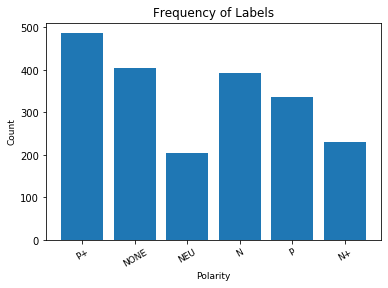

Prediction:


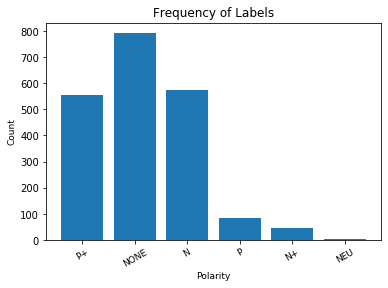

In [8]:
# split to 2 arrays, contents & scores
tweetsContents = [tweet[1] for tweet in tweets]
tweetsScores = [tweet[2] for tweet in tweets]

start = datetime.now()

# split for training + test
list_tweets_train, list_tweets_test, Y_train, Y_test = train_test_split(tweetsContents, tweetsScores, 
                                                                        test_size = 0.3, random_state = 0)

#Stopwords, ngrams, max_features lower the accuracy of the results. 
vec = CountVectorizer(tokenizer=tknzr.tokenize, preprocessor=cleanTweet) 
X_train = vec.fit_transform(list_tweets_train) # Learn the vocabulary 

# Train
modelo = RandomForestClassifier(n_estimators=500)
modelo.fit(X_train, Y_train)

# Predict test
X_test = vec.transform(list_tweets_test) # Apply vocabulary
prediction = modelo.predict(X_test)

# Evaluate
print("Finished in {}".format(datetime.now() - start))
evaluate(Y_test, prediction)

print("Real:")
plot_bar_x(Y_test)
print("Prediction:")
plot_bar_x(prediction)

modelSupervisedAccuracy = metrics.accuracy_score(Y_test, prediction)


## 2.4 Unsupervised + supervised

Columns to add
    - Count mentions
    - Count hashtags
    - Count urls
    - Count positive emojis
    - Count negative emojis
    - Length of tweet
    - Score number
    - Author


In [9]:
import random

def countMentions(tweet):
    return tweet.count('@')

def countHashtags(tweet):
    return tweet.count('#')

def countUrls(tweet):
    return len(re.findall(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', tweet))

def countPositiveEmojis(tweet):
    return len(re.findall(r':\)+|:-\)+|;\)+|xD+|XD+|=\)+|;-\)+', tweet))

def countNegativeEmojis(tweet):
    return len(re.findall(r':\(+|:-\(+|:/+|=/+|:\'\(', tweet))

def addTableColumn(X, col):
    return (hstack((X,np.array(col)[:,None])))

def createAuthorsIndexesList(authors):
    authorsDictionary = {}
    lastIndex = 0
    authorsIndexes = []
    
    for author in authors:
        if author in authorsDictionary:
            authorsIndexes.append(authorsDictionary[author])
        else:
            lastIndex += 1
            authorsDictionary[author] = lastIndex
            authorsIndexes.append(lastIndex)
    
    return authorsIndexes

### 2.4.1 Combining both methods

In [16]:
from scipy.sparse import hstack

tweetsContents = [tweet[1] for tweet in tweets]
tweetsScores = [tweet[2] for tweet in tweets]
tweetsAuthors = [tweet[3] for tweet in tweets]

authorsIndexes = createAuthorsIndexesList(tweetsAuthors)
mentionsNumber = [countMentions(tweet) for tweet in tweetsContents]
hashtagsNumber = [countHashtags(tweet) for tweet in tweetsContents]
urlsNumber = [countUrls(tweet) for tweet in tweetsContents]
positiveEmojisNumber = [countPositiveEmojis(tweet) for tweet in tweetsContents]
negativeEmojisNumber = [countNegativeEmojis(tweet) for tweet in tweetsContents]
lengths = [len(tweet) for tweet in tweetsContents]

start = datetime.now()

# Clean & tokenization
vec = CountVectorizer(tokenizer=tknzr.tokenize, preprocessor=cleanTweet)
X = vec.fit_transform(tweetsContents)

X = addTableColumn(X, count_pos)
X = addTableColumn(X, count_neg)
x = addTableColumn(X, authorsIndexes)
X = addTableColumn(X, scores)
X = addTableColumn(X, mentionsNumber)
X = addTableColumn(X, hashtagsNumber)
X = addTableColumn(X, urlsNumber)
X = addTableColumn(X, positiveEmojisNumber)
X = addTableColumn(X, negativeEmojisNumber)
X = addTableColumn(X, lengths)

print("Finished in {}".format(datetime.now() - start))

Finished in 0:00:00.781984


### 2.4.2 Model

Finished in 0:01:03.465784

Evaluación:
----------------------------------------
Hits: 319
Accuracy: 46.57%
Accuracy: 46.57%
----------------------------------------
Confusion_matrix:
[[ 74   7   0  20   0  21]
 [ 45  12   0  12   0   9]
 [ 29   1   1  14   1  18]
 [ 19   0   0  94   2  19]
 [ 37   3   0  29   8  47]
 [ 16   1   0  16   0 130]]
----------------------------------------
              precision    recall  f1-score   support

           N       0.34      0.61      0.43       122
          N+       0.50      0.15      0.24        78
         NEU       1.00      0.02      0.03        64
        NONE       0.51      0.70      0.59       134
           P       0.73      0.06      0.12       124
          P+       0.53      0.80      0.64       163

    accuracy                           0.47       685
   macro avg       0.60      0.39      0.34       685
weighted avg       0.57      0.47      0.40       685

Real:


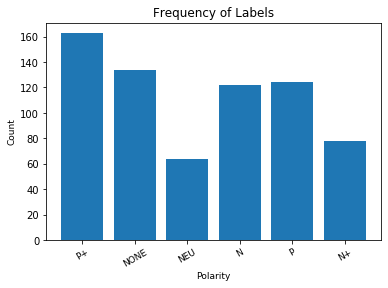

Prediction:


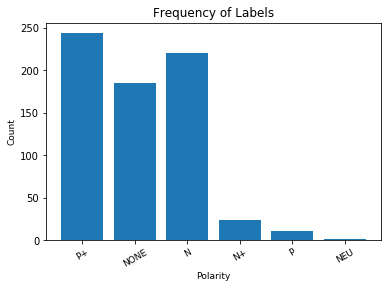

In [17]:
start = datetime.now()

# split for training + test
X_train, X_test, Y_train, Y_test = train_test_split(X, tweetsScores, 
                                                                        test_size = 0.1, random_state = 0)

# Train
modelo = RandomForestClassifier(n_estimators=500)
modelo.fit(X_train, Y_train)

# Predict test
prediction = modelo.predict(X_test)

# Evaluate
print("Finished in {}".format(datetime.now() - start))
evaluate(Y_test, prediction)

print("Real:")
plot_bar_x(Y_test)
print("Prediction:")
plot_bar_x(prediction)

modelCombinedAccuracy = metrics.accuracy_score(Y_test, prediction)


## 2.5 Conclusions

In [98]:
print("--- Resulting Accuracies ---\n")

print("Unsupervised:      {:.3}%".format(100*modelUnsupervisedAccuracy))
print("Supervised:        {:.3}%".format(100*modelSupervisedAccuracy))
print("Combined Methods:  {:.3}%".format(100*modelCombinedAccuracy))

--- Resulting Accuracies ---

Unsupervised:      36.6%
Supervised:        41.5%
Combined Methods:  46.6%


# 3. Test tweets
Descargar los tweets de test a partir del id `TASS_test_ids.txt`. Ver fichero `descarga_tweets` para el codigo. 

## 3.1 Prepare data

In [220]:
testTweetsContents =  [tweet[1] for tweet in testTweets]

testTweetsAuthors = [tweet[2] for tweet in testTweets]

testScores = []
testPredictions = []
testPositiveCounts = []
testNegativeCounts = []

for idx, tweet in enumerate(testTweets):
    polarizedData = polarizeData(tweet)

    testScores.append(polarizedData[0])
    testPredictions.append(polarizedData[1])   
    testPositiveCounts.append(polarizedData[2])   
    testNegativeCounts.append(polarizedData[3])   
    
testAuthorsIndexes = createAuthorsIndexesList(testTweetsAuthors)
testMentionsNumber = [countMentions(tweet) for tweet in testTweetsContents]
testHashtagsNumber = [countHashtags(tweet) for tweet in testTweetsContents]
testUrlsNumber = [countUrls(tweet) for tweet in testTweetsContents]
testPositiveEmojisNumber = [countPositiveEmojis(tweet) for tweet in testTweetsContents]
testNegativeEmojisNumber = [countNegativeEmojis(tweet) for tweet in testTweetsContents]
testLengths = [len(tweet) for tweet in testTweetsContents]

print("Done with {} rows".format(len(lengths)))

Done with 57415 rows


### 3.1.1 Test individual tweet

In [217]:
example_tweet = testTweets[randint(1,len(tweets))][1]
print(example_tweet)

print("\n    Number of hashtags: ", countHashtags(example_tweet))
print("    Number of mentions: ", countMentions(example_tweet))
print("    Number of positive emojis: ", countPositiveEmojis(example_tweet))
print("    Number of negative emojis: ", countNegativeEmojis(example_tweet))
print("    Number of links: ", countUrls(example_tweet))
examplePolarizedData = polarizeData(example_tweet)

print("    Count positive: ", examplePolarizedData[2])
print("    Count negative: ", examplePolarizedData[3])
print("    Polarity Difference:", examplePolarizedData[0])
print("    Prediction:", examplePolarizedData[1])
print("    Length of tweet: ", len(example_tweet))

Mourinho se hace pasar por entrenador del Atleti: dice que el Madrid ha perdido por mala suerte...

    Number of hashtags:  0
    Number of mentions:  0
    Number of positive emojis:  0
    Number of negative emojis:  0
    Number of links:  0
    Count positive:  0
    Count negative:  0
    Polarity Difference: 0
    Prediction: NONE
    Length of tweet:  98


## 3.2 Matrix of features

In [235]:
start = datetime.now()

vec_test = CountVectorizer(tokenizer=tknzr.tokenize, preprocessor=cleanTweet, vocabulary = vec.get_feature_names())
X_test = vec_test.transform(testTweetsContents)

beforeMatrixSize = X_test.size

X_test = addTableColumn(X_test, testPositiveCounts)
X_test = addTableColumn(X_test, testNegativeCounts)
x_test = addTableColumn(X_test, testAuthorsIndexes)
X_test = addTableColumn(X_test, testScores)
X_test = addTableColumn(X_test, testMentionsNumber)
X_test = addTableColumn(X_test, testHashtagsNumber)
X_test = addTableColumn(X_test, testUrlsNumber)
X_test = addTableColumn(X_test, testPositiveEmojisNumber)
X_test = addTableColumn(X_test, testNegativeEmojisNumber)
X_test = addTableColumn(X_test, testLengths)

print("Finished in {}, matrix is {:.5}% bigger".format(datetime.now() - start, 100*(X_test.size-beforeMatrixSize)/beforeMatrixSize))

Finished in 0:00:06.696119, matrix is 30.81% bigger


## 3.3 Tag tweets and save results

In [243]:
final_prediction = modelo.predict(X_test)
final_ids = [row[0] for row in testTweets]

final_data = []

for i in range(len(final_prediction)):
    row = final_ids[i], final_prediction[i]
    final_data.append(row)

saveFile('final_submission.txt', final_data)